#Proyecto Módulo 4

##Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import re #Expresiones regulares
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

##Enriquecimiento de datos
Se tiene un excel con datos de ventas, pero para mejorar el análisis se agregarán algunas columnas con valores aleatorios.

In [147]:
df_bruto = pd.read_excel('registro_ventas.xlsx', sheet_name='Ventas')

In [148]:
print(f"Dimensiones archivo cargado: {df_bruto.shape[0]} filas, {df_bruto.shape[1]} columnas")
print(f"\nColumnas actuales:\n{df_bruto.columns}")
print(f"\nTipos de datos:\n{df_bruto.dtypes}")
print(f"\nValores faltantes:\n{df_bruto.isnull().sum()}")

Dimensiones archivo cargado: 1450 filas, 10 columnas

Columnas actuales:
Index(['ID', 'Producto', 'Fecha', 'DTE', 'N. DTE', 'Neto', 'IVA', 'Total',
       'Costo venta', 'Ganancia Bruta'],
      dtype='object')

Tipos de datos:
ID                         int64
Producto                  object
Fecha             datetime64[ns]
DTE                       object
N. DTE                    object
Neto                     float64
IVA                      float64
Total                    float64
Costo venta               object
Ganancia Bruta           float64
dtype: object

Valores faltantes:
ID                   0
Producto             0
Fecha                2
DTE                 69
N. DTE             100
Neto                56
IVA                  3
Total                1
Costo venta       1208
Ganancia Bruta    1333
dtype: int64


In [149]:
#Copia el archivo bruto en un nuevo dataframe sobre el que trabajaremos
df = df_bruto.copy()

In [150]:
#Limpieza inicial de datos
#Asegura columna fecha con dato tipo fecha
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')

columnas_num = ['Costo venta', 'Total', 'Ganancia Bruta']
for col in columnas_num:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#Reemplaza los strings no numericos por -1 para indicar que no existe ese numero de dte
df['N. DTE'] = pd.to_numeric(df['N. DTE'], errors='coerce').fillna(-1).astype(int)


# Rellenar Neto / IVA en base a Total asumiendo IVA 19%
if "Neto" in df.columns and "IVA" in df.columns:
    mask_total = df["Total"].notna()
    df.loc[mask_total & df["Neto"].isna(), "Neto"] = df["Total"] / 1.19
    df.loc[mask_total & df["IVA"].isna(), "IVA"] = df["Total"] - df["Neto"]


#########CREACION DE NUEVAS COLUMNAS################
#----------Agrega columna medio de pago
np.random.seed(42)
medios_pago = ['Transferencia', 'Efectivo', 'Tarjeta Débito', 'Tarjeta Crédito']
prob= [0.35, 0.25, 0.25, 0.15]
df['Medio_de_pago'] = np.random.choice(medios_pago, size=len(df), p=prob)

#----------Estado del pago  ***********REVISAR***********
def asignar_estado_pago(medio):
    if medio in ["Transferencia"]:
        return np.random.choice(["Pagado", "Pendiente", "Parcial"], p=[0.75, 0.15, 0.10])
    elif medio in ["Tarjeta Crédito", "Tarjeta Débito"]:
        return np.random.choice(["Pagado", "Pendiente"], p=[0.90, 0.10])
    else:
        return np.random.choice(["Pagado", "Pendiente", "Parcial"], p=[0.60, 0.30, 0.10])

df["estado_pago"] = df["Medio_de_pago"].apply(asignar_estado_pago)

#----------Creación columna tipo de cliente
def tipo_cliente(row):
  if row['DTE'] == 'Factura':
    return 'Empresa'
  elif row['DTE'] == 'Boleta' or row['DTE'] == 'C. Venta' or pd.isna(row['DTE']):
    cat_cliente = ['Nuevo', 'Frecuente', 'VIP']
    prob_clientes = [0.3, 0.6, 0.1]
    return np.random.choice(cat_cliente, size=1, p=prob_clientes)[0]
  else:
    return 'Nuevo'

df['Tipo Cliente'] = df.apply(tipo_cliente, axis=1)

#-----------Entrega o retiro por cliente
entrega= ['Local', 'Domicilio']
df['Entrega'] = np.random.choice(entrega, size=len(df), p=[0.6, 0.4])

#-----------Categoría de venta
cat_venta = ['Tradicional', 'Ecommerce']
df['Categoría_venta'] = np.random.choice(cat_venta, size=len(df), p=[0.8,0.2])

# ---------------- DÍAS_DESDE_COMPRA ----------------
fecha_ref = df["Fecha"].max()
df["Dias_desde_compra"] = (fecha_ref - df["Fecha"]).dt.days

# ---------------- CANTIDAD_ITEMS ----------------
def contar_productos(descripcion):
    if pd.isna(descripcion) or descripcion == "":
        return 0
    #Dividimos por coma o signo más
    partes = re.split(r'[,\+]', str(descripcion))
    #Filtramos para no contar espacios vacíos
    items_validos = [p.strip() for p in partes if p.strip()]
    return len(items_validos)

df['Cantidad'] = df['Producto'].apply(contar_productos)


# ---------------- ESTACIONALIDAD ----------------
def estacionalidad(fecha):
    if pd.isna(fecha):
        return "Desconocido"
    mes = fecha.month
    if mes in [1, 2, 3]:
        return "Q1"
    if mes in [4, 5, 6]:
        return "Q2"
    if mes in [7, 8, 9]:
        return "Q3"
    return "Q4"

df["estacionalidad"] = df["Fecha"].apply(estacionalidad)

#----------------Eliminación columna ID-------------
df.drop(columns='ID', inplace=True)

In [151]:
#columnas del dataset
df.columns.to_list()

['Producto',
 'Fecha',
 'DTE',
 'N. DTE',
 'Neto',
 'IVA',
 'Total',
 'Costo venta',
 'Ganancia Bruta',
 'Medio_de_pago',
 'estado_pago',
 'Tipo Cliente',
 'Entrega',
 'Categoría_venta',
 'Dias_desde_compra',
 'Cantidad',
 'estacionalidad']

##Lección 1: Análisis exploratorio de datos

In [152]:
#Descripción básica
df.describe()

,Fecha,N. DTE,Neto,IVA,Total,Costo venta,Ganancia Bruta,Dias_desde_compra,Cantidad
count,1448,1450.000000,1449.000000,1449.000000,1449.00000,240.000000,117.000000,1448.000000,1450.000000
mean,2023-10-27 05:06:17.900552704,66251.828966,34001.101024,6460.209036,40461.31006,27190.921604,21300.217564,841.787293,1.774483
min,2021-01-05 00:00:00,-1.000000,0.000000,0.000000,0.00000,2072.000000,350.000000,0.000000,1.000000
25%,2022-07-13 18:00:00,180.250000,13445.378000,2554.621820,15999.99982,8990.000000,10310.790000,356.750000,1.000000
50%,2023-11-02 12:00:00,91353.500000,26050.420000,4949.579800,30999.99980,19583.535000,19585.750000,835.500000,1.000000
75%,2025-02-23 06:00:00,91715.750000,42016.810000,7983.193900,50000.00390,35494.742500,26161.874000,1312.250000,2.000000
max,2026-02-15 00:00:00,92078.000000,370836.130000,70458.864700,441294.99470,151920.000000,97749.740000,1867.000000,7.000000
std,NaN,40936.247207,34485.257457,6552.199173,41037.45663,25562.676160,15857.484776,524.745371,1.095589


In [153]:
#ANÁLISIS EXPLORATORIO INICIAL (EDA)

print("=" * 60)
print("RESUMEN DEL DATASET ENRIQUECIDO")
print("=" * 60)
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"Período: {df['Fecha'].min()} → {df['Fecha'].max()}")
print(f"Año inicial análisis: {int(df['Fecha'].dt.year.min())} \nAño final análisis: {int(df['Fecha'].dt.year.max())}")
print(f"Total ventas: ${df['Total'].sum():,.0f}")
print(f"Cantidad total de productos vendidos: {df['Cantidad'].sum()}")
print()

# Tipos de variables
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Variables cuantitativas:", len(num_cols))
print(num_cols)
print()
print("Variables categóricas:", len(cat_cols))
print(cat_cols)
print()

# Calidad datos
print("Calidad datos:")
print(f"Valores faltantes totales: {df.isnull().sum().sum()}")
print(f"Duplicados: {df.duplicated().sum()}")

RESUMEN DEL DATASET ENRIQUECIDO
Dimensiones: 1,450 filas × 17 columnas
Período: 2021-01-05 00:00:00 → 2026-02-15 00:00:00
Año inicial análisis: 2021 
Año final análisis: 2026
Total ventas: $58,628,438
Cantidad total de productos vendidos: 2573

Variables cuantitativas: 8
['N. DTE', 'Neto', 'IVA', 'Total', 'Costo venta', 'Ganancia Bruta', 'Dias_desde_compra', 'Cantidad']

Variables categóricas: 8
['Producto', 'DTE', 'Medio_de_pago', 'estado_pago', 'Tipo Cliente', 'Entrega', 'Categoría_venta', 'estacionalidad']

Calidad datos:
Valores faltantes totales: 2619
Duplicados: 0


###Valores faltantes e inconsistencias

In [154]:
#Hay 2 valores faltantes en la columna fecha
print(f"Valores Na en Fecha: {df['Fecha'].isna().sum()}")
print("Filas con Fecha Na:")
print(df[df['Fecha'].isna()][['Producto', 'DTE', 'Total']].head())

#al revisar los datos que tiene la fila y como no tiene ni nro de DTE ni Total de venta es mejor eliminar ambas filas
df.dropna(subset=['Fecha'], inplace=True)

#Comprobación de eliminación
print(f"Valores Na en Fecha: {df['Fecha'].isna().sum()}")

Valores Na en Fecha: 2
Filas con Fecha Na:
                            Producto     DTE  Total
174          Empaquetadura Chev Aveo     NaN    NaN
727  Boleta nula (se salto el folio)  Boleta    0.0
Valores Na en Fecha: 0


In [155]:
#Imputación de valor a DTE
df['DTE'].fillna('Sin DTE', inplace=True)

#Para imputar los valores faltantes de la ganancia bruta se considerará una ganancia de entre un 30% y 40% del valor total
df['Ganancia Bruta'] = df['Ganancia Bruta'].fillna(np.random.uniform(0.30, 0.40, size= df['Ganancia Bruta'].isna().sum())*df.loc[df['Ganancia Bruta'].isna(), 'Total'])



In [156]:
#Si el costo de venta es 0 entonces -> total - ganancia bruta = costo venta
mask_cero = df['Costo venta'].isna() & df['Total'].notna() & df['Ganancia Bruta'].notna()
df.loc[mask_cero, 'Costo venta'] = df.loc[mask_cero, 'Total'] - df.loc[mask_cero, 'Ganancia Bruta']


In [157]:
#Hay 53 filas que tienen valor 0 en monto Total, IVA y Neto, por lo que no es
#posible calcular un valor a partir del otro
#serán convertidos a nulos para ver con más claridad
cols = ['Neto', 'IVA', 'Total']
for col in cols:
  df[col] = pd.to_numeric(df[col], errors='coerce').replace(0, np.nan)

df.dropna(subset = cols, how='all', inplace=True)

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1395 entries, 0 to 1449
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Producto           1395 non-null   object        
 1   Fecha              1395 non-null   datetime64[ns]
 2   DTE                1395 non-null   object        
 3   N. DTE             1395 non-null   int64         
 4   Neto               1395 non-null   float64       
 5   IVA                1395 non-null   float64       
 6   Total              1395 non-null   float64       
 7   Costo venta        1395 non-null   float64       
 8   Ganancia Bruta     1395 non-null   float64       
 9   Medio_de_pago      1395 non-null   object        
 10  estado_pago        1395 non-null   object        
 11  Tipo Cliente       1395 non-null   object        
 12  Entrega            1395 non-null   object        
 13  Categoría_venta    1395 non-null   object        
 14  Dias_desde_co

In [159]:
print(df.isnull().sum())

Producto             0
Fecha                0
DTE                  0
N. DTE               0
Neto                 0
IVA                  0
Total                0
Costo venta          0
Ganancia Bruta       0
Medio_de_pago        0
estado_pago          0
Tipo Cliente         0
Entrega              0
Categoría_venta      0
Dias_desde_compra    0
Cantidad             0
estacionalidad       0
dtype: int64


Hallazgos:

Al realizar el análisis inicial de los datos se puede observar que hay una serie de datos que faltan, que corresponden a valores nulos o ceros. Por ello se realiza una limpieza e imputación de datos en función de mejorar la calidad de estos y tener un mejor análisis en etapas posteriores.

Para los DTE sin número se les imputa el valor -1, ya que si bien no es un factor de análisis, se opta por dejarlo "marcado" para tenerlo presente en caso de necesitar ver algún número de DTE en particular y que no se confunda con el resto.

In [160]:
df.describe()

,Fecha,N. DTE,Neto,IVA,Total,Costo venta,Ganancia Bruta,Dias_desde_compra,Cantidad
count,1395,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000,1395.000000
mean,2023-11-27 09:57:40.645160960,68796.001434,35317.272677,6710.281644,42027.554320,27429.945879,14795.757928,810.584946,1.805018
min,2021-01-05 00:00:00,-1.000000,1261.000000,239.590000,1500.590000,0.000000,350.000000,0.000000,1.000000
25%,2022-08-29 00:00:00,91024.500000,16806.720000,3193.276800,19999.996800,12288.105527,6299.884259,346.000000,1.000000
50%,2023-12-05 00:00:00,91380.000000,27731.090000,5268.907100,32999.997100,21250.000000,11079.134330,803.000000,1.000000
75%,2025-03-06 00:00:00,91729.500000,42857.141429,8142.856871,50999.998300,33673.526012,18284.927774,1266.000000,2.000000
max,2026-02-15 00:00:00,92078.000000,370836.130000,70458.864700,441294.994700,298896.288503,145664.267366,1867.000000,7.000000
std,NaN,39563.181921,34478.745510,6550.961919,41029.707429,26932.818422,14779.801493,508.559413,1.105927


In [161]:
#exportar a archivo excel
df.to_excel('limpio_con_columnas_extras.xlsx', index=False)

##Lección 2: CONCEPTOS BÁSICOS DE ESTADÍSTICA DESCRIPTIVA



In [162]:
#Tabla estadística clave
metricas_clave = df[["Total", "Neto", "IVA", "Costo venta", "Ganancia Bruta",
                    "Cantidad", "Dias_desde_compra"]].describe().round(2)
print("Métricas descriptivas:")
metricas_clave

Métricas descriptivas:


,Total,Neto,IVA,Costo venta,Ganancia Bruta,Cantidad,Dias_desde_compra
count,1395.00,1395.00,1395.00,1395.00,1395.00,1395.00,1395.00
mean,42027.55,35317.27,6710.28,27429.95,14795.76,1.81,810.58
std,41029.71,34478.75,6550.96,26932.82,14779.80,1.11,508.56
min,1500.59,1261.00,239.59,0.00,350.00,1.00,0.00
25%,20000.00,16806.72,3193.28,12288.11,6299.88,1.00,346.00
50%,33000.00,27731.09,5268.91,21250.00,11079.13,1.00,803.00
75%,51000.00,42857.14,8142.86,33673.53,18284.93,2.00,1266.00
max,441294.99,370836.13,70458.86,298896.29,145664.27,7.00,1867.00


In [163]:
#Medidas de tendencia central
print("Medidas de tendencia central:")
columnas = ['Total', 'Neto', 'IVA','Costo venta', 'Ganancia Bruta', 'Cantidad', 'Dias_desde_compra']
tabla_estadistica = df[columnas].agg(['mean', 'median', 'var', 'std']).T
tabla_estadistica['mode'] = df[columnas].mode().iloc[0]

tabla_estadistica.columns = ['Media', 'Mediana', 'Varianza', 'Desviación estándar', 'Moda']

tabla_estadistica

Medidas de tendencia central:


,Media,Mediana,Varianza,Desviación estándar,Moda
Total,42027.554320,32999.99710,1.683437e+09,41029.707429,20000.33
Neto,35317.272677,27731.09000,1.188784e+09,34478.745510,16807.00
IVA,6710.281644,5268.90710,4.291510e+07,6550.961919,3193.33
Costo venta,27429.945879,21250.00000,7.253767e+08,26932.818422,2975.00
Ganancia Bruta,14795.757928,11079.13433,2.184425e+08,14779.801493,5000.00
Cantidad,1.805018,1.00000,1.223074e+00,1.105927,1.00
Dias_desde_compra,810.584946,803.00000,2.586327e+05,508.559413,260.00


In [164]:
#Cuartiles y Percentiles
print("Análisis de Cuartiles y Percentiles:")
columnas = ['Total', 'Neto', 'IVA','Costo venta', 'Ganancia Bruta']

#tabla de cuartiles
tabla_cuartiles = df[columnas].quantile([0.25, 0.5, 0.75, 0.95]).T
tabla_cuartiles.columns = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)', 'P95']

#tabla de percentiles
tabla_cuartiles.round(2)

Análisis de Cuartiles y Percentiles:


,Q1 (25%),Q2 (50%),Q3 (75%),P95
Total,20000.00,33000.00,51000.00,117000.00
Neto,16806.72,27731.09,42857.14,98319.33
IVA,3193.28,5268.91,8142.86,18680.67
Costo venta,12288.11,21250.00,33673.53,74350.31
Ganancia Bruta,6299.88,11079.13,18284.93,41029.89


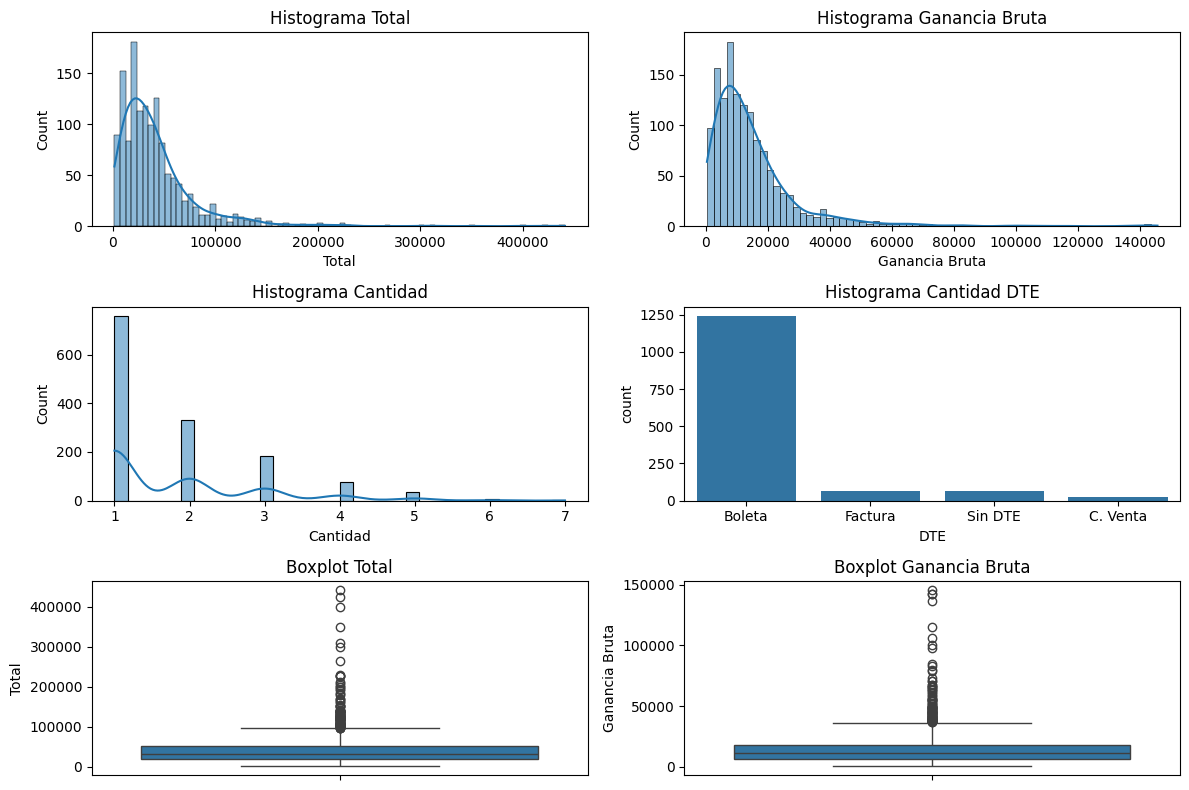

In [165]:
# Gráficos básicos
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

# Histogramas
sns.histplot(df["Total"].dropna(), kde=True, ax=axes[0,0])
axes[0,0].set_title("Histograma Total")

sns.histplot(df["Ganancia Bruta"].dropna(), kde=True, ax=axes[0,1])
axes[0,1].set_title("Histograma Ganancia Bruta")

sns.histplot(df["Cantidad"].dropna(), kde=True, ax=axes[1,0])
axes[1,0].set_title("Histograma Cantidad")

sns.countplot(data=df, x="DTE", ax=axes[1,1])
axes[1,1].set_title("Histograma Cantidad DTE")

# Boxplots
sns.boxplot(data=df, y="Total", ax=axes[2,0])
axes[2,0].set_title("Boxplot Total")

sns.boxplot(data=df, y="Ganancia Bruta", ax=axes[2,1])
axes[2,1].set_title("Boxplot Ganancia Bruta")

plt.tight_layout()
plt.show()

In [166]:
#Cálculo de outliers con IQR

print("Cálculo de Outliers con IQR:")
print("="*60)

def detectar_outliers_iqr(df, columna):
    # Calculamos los cuartiles 1 y 3
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)

    # Calculamos el Rango Intercuartílico
    IQR = Q3 - Q1

    # Definimos los límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Creamos la máscara para los atípicos
    mask_outliers = (df[columna] < limite_inferior) | (df[columna] > limite_superior)

    return df[mask_outliers], (limite_inferior, limite_superior)

# Uso del código

outliers, limites = detectar_outliers_iqr(df, 'Total')
print(f"Límites calculados: {limites}")
print(f"Número de atípicos encontrados: {len(outliers)}")

Cálculo de Outliers con IQR:
Límites calculados: (np.float64(-26500.005449999997), np.float64(97500.00055))
Número de atípicos encontrados: 105


###Análisis de Outliers
Se profundiza un poco en estos datos atípicos

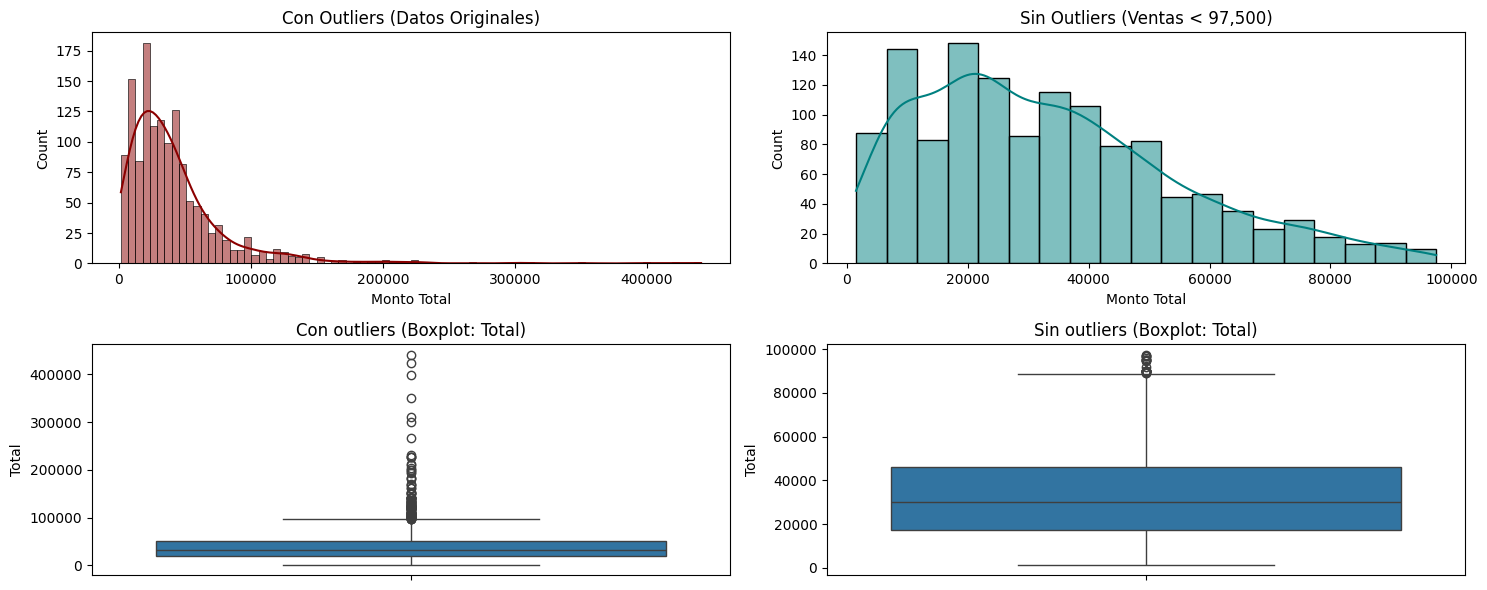

In [167]:
#Compararemos histogramas de Total ventas con y sin outliers
# 1. Definimos los datos (con y sin outliers según tu límite de 97,500)
datos_completos = df['Total'].dropna()
datos_filtrados = df[df['Total'] <= 97500]['Total'].dropna()

# 2. Creamos la figura con dos subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 6), sharey=False)

# Gráfico 1: Con Outliers (Tu realidad actual)
sns.histplot(datos_completos, kde=True, color='darkred', ax=axes[0,0])
axes[0,0].set_title('Con Outliers (Datos Originales)')
axes[0,0].set_xlabel('Monto Total')

# Gráfico 2: Sin Outliers (Zoom al comportamiento normal)
sns.histplot(datos_filtrados, kde=True, color='teal', ax=axes[0,1])
axes[0,1].set_title('Sin Outliers (Ventas < 97,500)')
axes[0,1].set_xlabel('Monto Total')

#Aprovechamos de comparar utilizando boxplots
sns.boxplot(data=df, y = datos_completos, ax=axes[1,0])
axes[1,0].set_title("Con outliers (Boxplot: Total)")

sns.boxplot(data=df, y = datos_filtrados, ax=axes[1,1])
axes[1,1].set_title("Sin outliers (Boxplot: Total)")

plt.tight_layout()
plt.show()

Como es posible apreciar, los datos se ven distintos cuando quitamos los outliers. Por conocimiento previo, estos datos no corresponden a errores, solo son ventas de mayor valor.

A continuación se calculará el monto total de esos valores atipicos y cuanto porcentaje representan.

In [168]:
# 1. Calculamos los montos totales
total_general = df['Total'].sum()
total_atipicos = df[df['Total'] > 97500]['Total'].sum()

# 2. Calculamos porcentajes
porcentaje_dinero = (total_atipicos / total_general) * 100
porcentaje_filas = (len(df[df['Total'] > 97500]) / len(df)) * 100

# 3. Mostramos los resultados
print(f"--- RESUMEN DE IMPACTO ---")
print(f"Venta Total General: ${total_general:,.0f}")
print(f"Venta Total Atípicos: ${total_atipicos:,.0f}")
print(f"--------------------------")
print(f"Representan el {porcentaje_dinero:.2f}% del dinero total.")
print(f"Representan el {porcentaje_filas:.2f}% de las transacciones.")

--- RESUMEN DE IMPACTO ---
Venta Total General: $58,628,438
Venta Total Atípicos: $15,652,353
--------------------------
Representan el 26.70% del dinero total.
Representan el 7.53% de las transacciones.


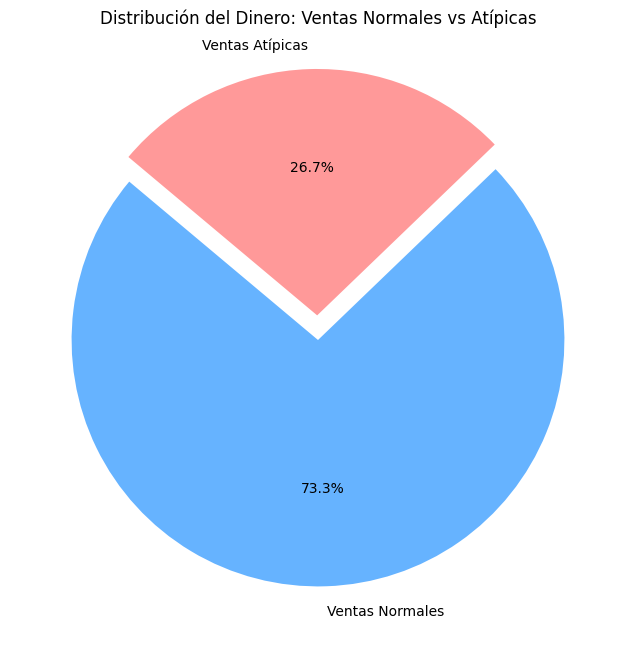

In [169]:
labels = ['Ventas Normales', 'Ventas Atípicas']
sizes = [total_general - total_atipicos, total_atipicos]
colors = ['#66b3ff','#ff9999']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0, 0.1))
plt.title('Distribución del Dinero: Ventas Normales vs Atípicas')
plt.show()

In [170]:
df['Año'] = df['Fecha'].dt.year

In [171]:
# Definimos la marca de atípico (el límite que calculamos antes)
limite_superior = 97500

# Creamos una columna booleana para identificar atípicos fácilmente
df['es_atipico'] = df['Total'] > limite_superior

# Agrupamos por año para ver la distribución
analisis_anual = df.groupby('Año').agg(
    Cant_Atipicos=('es_atipico', 'sum'),
    Dinero_Atipicos=('Total', lambda x: x[df.loc[x.index, 'es_atipico']].sum()),
    Venta_Total_Año=('Total', 'sum')
)

# Calculamos el peso del dinero atípico por año
analisis_anual['%_Peso_Dinero'] = (analisis_anual['Dinero_Atipicos'] / analisis_anual['Venta_Total_Año']) * 100

print(analisis_anual)

      Cant_Atipicos  Dinero_Atipicos  Venta_Total_Año  %_Peso_Dinero
Año                                                                 
2021              7     9.587616e+05     3.997117e+06      23.986327
2022             11     1.440400e+06     8.399465e+06      17.148712
2023             21     3.347300e+06     1.183565e+07      28.281492
2024             18     2.446101e+06     1.105170e+07      22.133259
2025             42     6.654892e+06     2.098772e+07      31.708497
2026              6     8.048980e+05     2.356778e+06      34.152474


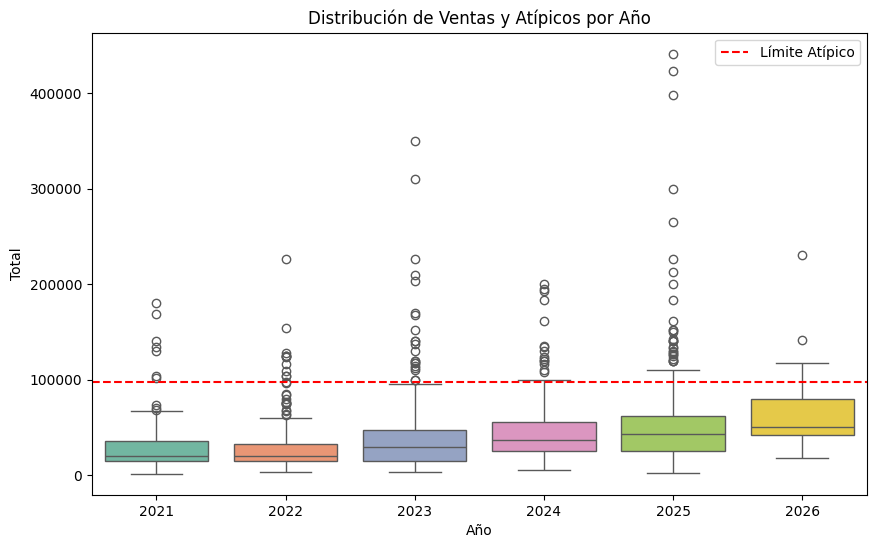

In [172]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Año', y='Total', palette='Set2')
plt.axhline(limite_superior, color='red', linestyle='--', label='Límite Atípico')
plt.title('Distribución de Ventas y Atípicos por Año')
plt.legend()
plt.show()

Se aprecia un aumento sostenido año tras año en el monto total de ventas, aún así hay valores atípicos que están

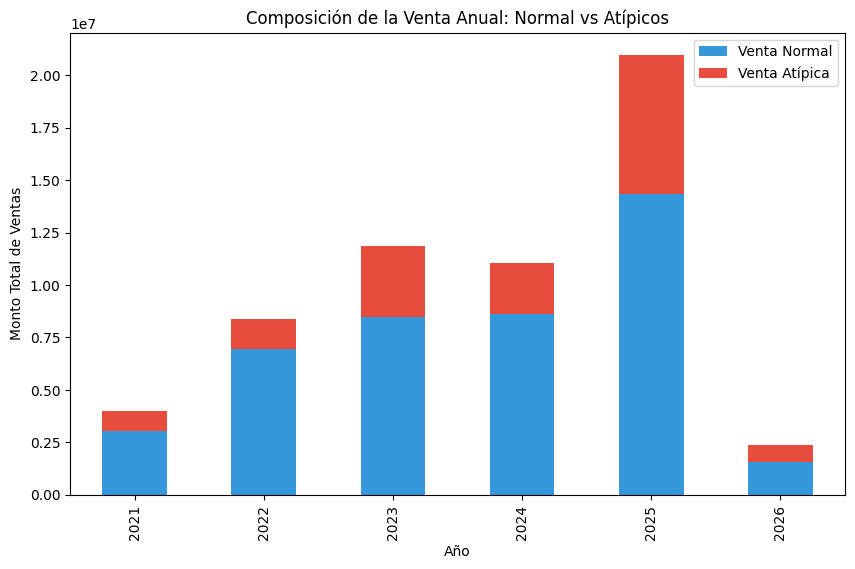

In [173]:
# Preparar datos para el gráfico
analisis_anual['Venta_Normal'] = analisis_anual['Venta_Total_Año'] - analisis_anual['Dinero_Atipicos']

# Graficar
analisis_anual[['Venta_Normal', 'Dinero_Atipicos']].plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=['#3498db', '#e74c3c']
)
plt.title('Composición de la Venta Anual: Normal vs Atípicos')
plt.ylabel('Monto Total de Ventas')
plt.xlabel('Año')
plt.legend(['Venta Normal', 'Venta Atípica'])
plt.show()

El negocio tiene dos tipos de venta principales: las ventas "normales" y las ventas "atípicas", ambas han ido en crecimiento.

In [174]:
# Filtramos solo los atípicos
df_atipicos = df[df['Total'] > 97500].copy()

# Conteo por tipo de DTE en los atípicos
conteo_dte_atipicos = df_atipicos['DTE'].value_counts()
porcentaje_dte_atipicos = df_atipicos['DTE'].value_counts(normalize=True) * 100

print("--- DISTRIBUCIÓN DE ATÍPICOS POR DTE ---")
for dte, count in conteo_dte_atipicos.items():
    print(f"{dte}: {count} ventas ({porcentaje_dte_atipicos[dte]:.1f}%)")

--- DISTRIBUCIÓN DE ATÍPICOS POR DTE ---
Boleta: 86 ventas (81.9%)
Factura: 18 ventas (17.1%)
Sin DTE: 1 ventas (1.0%)


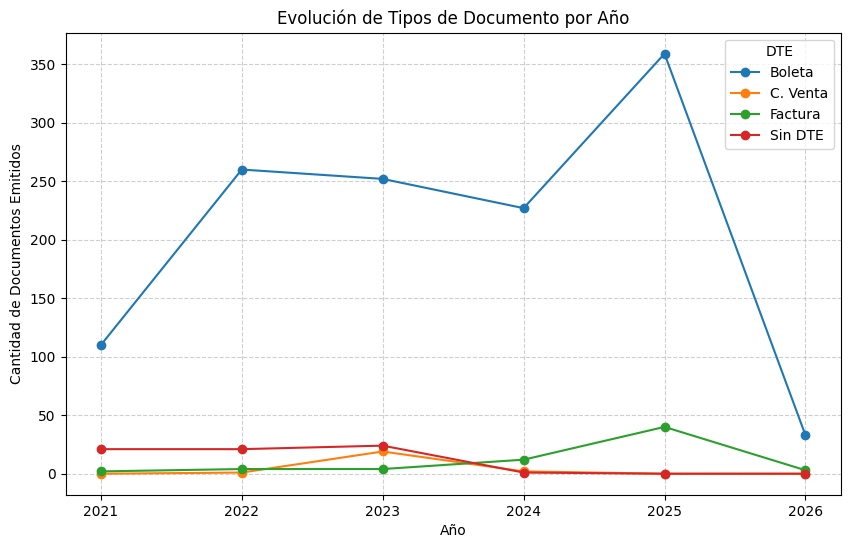

In [175]:
# Agrupamos por año y por tipo de DTE
evolucion_dte = df.groupby(['Año', 'DTE']).size().unstack(fill_value=0)

# Graficamos la evolución para ver el salto
evolucion_dte.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Evolución de Tipos de Documento por Año')
plt.ylabel('Cantidad de Documentos Emitidos')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [176]:
ticket_promedio_dte = df.groupby('DTE')['Total'].mean().sort_values(ascending=False)
print("\n--- TICKET PROMEDIO POR DTE ---")
print(ticket_promedio_dte.apply(lambda x: f"${x:,.0f}"))


--- TICKET PROMEDIO POR DTE ---
DTE
Factura     $82,699
Boleta      $41,190
Sin DTE     $26,635
C. Venta    $16,009
Name: Total, dtype: object


Como conclusión del análisis de outliers se puede decir que si bien modifican el comportamiento de las ventas, no es buena idea dejarlos fuera del análisis debido a que corresponden al comportamiento del negocio. Se ve evidencia de que hay dos tipos de venta, lo que se puede complementar con conocimiento sobre el negocio:

Los valores "normales" corresponden a ventas de productos de mantención (lubricantes, filtros, aditivos), mientras que las valores atípicos corresponden a ventas de repuestos para mantenciones mayores, como podría ser kit de distribución + bomba de agua + kit de empaquetaduras.



**NOTA:
Para continuar el análisis se considerarán estos valores atípicos para no distorsionar la realidad del negocio, aunque está demás decir que para otro tipo de análisis si se pueden quitar y tener un comportamiento más "normal" de los datos.**

##Lección 3: CORRELACIÓN

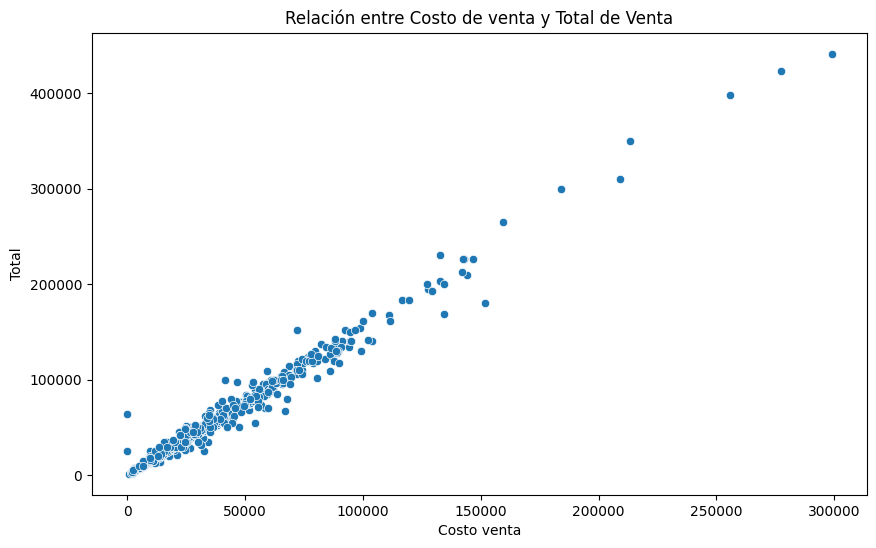

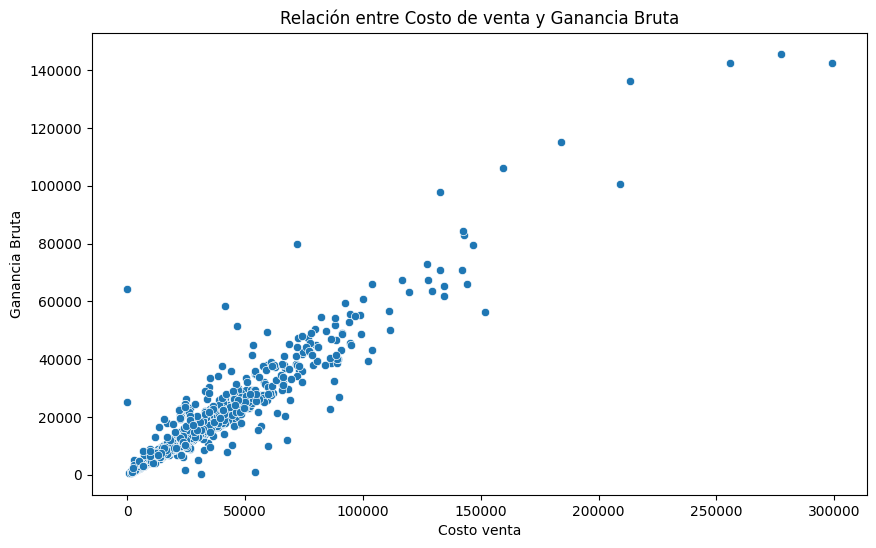

In [177]:
#Scatterplots
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Costo venta', y='Total')

plt.title('Relación entre Costo de venta y Total de Venta')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Costo venta', y='Ganancia Bruta')

plt.title('Relación entre Costo de venta y Ganancia Bruta')
plt.show()

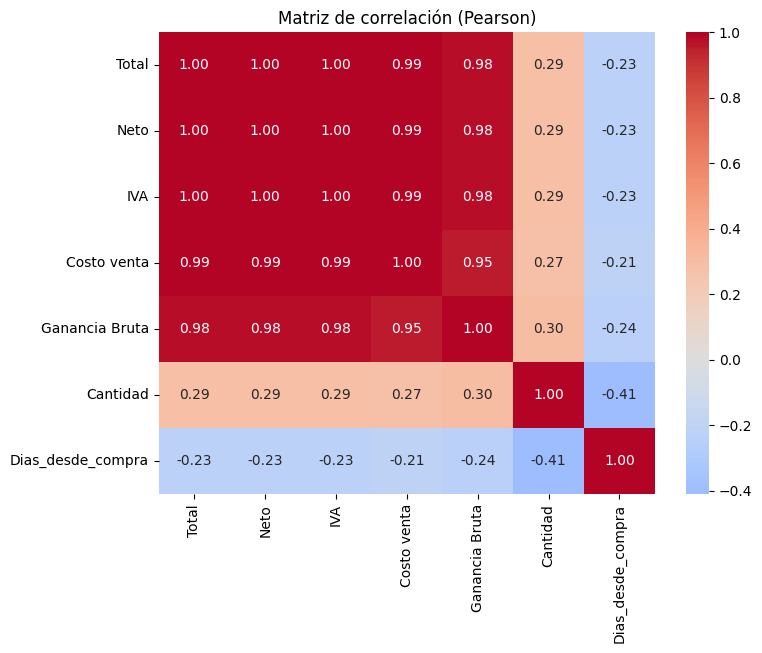

Correlaciones fuertes (>0.8):


Neto            Total             1.000000
IVA             Total             1.000000
                Neto              1.000000
Neto            Costo venta       0.992317
Costo venta     Total             0.992317
                IVA               0.992317
Ganancia Bruta  IVA               0.981406
                Total             0.981406
Neto            Ganancia Bruta    0.981406
Costo venta     Ganancia Bruta    0.953546
dtype: float64

In [179]:
# Matriz de correlación
corr_cols = ["Total", "Neto", "IVA", "Costo venta", "Ganancia Bruta",
             "Cantidad", "Dias_desde_compra"]
corr_matrix = df[corr_cols].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Matriz de correlación (Pearson)")
plt.show()

print("Correlaciones fuertes (>0.8):")
correl_fuertes = corr_matrix.unstack().sort_values(ascending=False)
correl_fuertes[(correl_fuertes > 0.8) & (correl_fuertes < 1)].drop_duplicates()

In [180]:
#Correlación cantidad/total ventas
correlacion_especifica = df['Cantidad'].corr(df['Total'], method='pearson')
print(f"El coeficiente de Pearson para Cantidad vs Total es: {correlacion_especifica:,.4f}")

#Correlación total/costo venta
correlacion_especifica = df['Total'].corr(df['Costo venta'], method='pearson')
print(f"El coeficiente de Pearson para Total vs Costo venta es: {correlacion_especifica:,.4f}")

#Correlación ganancia bruta/costo venta
correlacion_especifica = df['Ganancia Bruta'].corr(df['Costo venta'], method='pearson')
print(f"El coeficiente de Pearson para Ganancia Bruta vs Costo venta es: {correlacion_especifica:,.4f}")

El coeficiente de Pearson para Cantidad vs Total es: 0.2868
El coeficiente de Pearson para Total vs Costo venta es: 0.9923
El coeficiente de Pearson para Ganancia Bruta vs Costo venta es: 0.9535


Debido a la naturaleza de los datos que se usaron no se encontraron relaciones espurias. Los datos están efectivamente relacionados unos con otros ya que Neto, IVA, Total se calculan uno a partir del otro, de igual manera el costo de venta se utiliza para calcular el precio total de la venta.

##Lección 4: REGRESIONES LINEALES

Regresión lineal: Total ~ Cantidad
                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     124.8
Date:                Thu, 19 Feb 2026   Prob (F-statistic):           8.05e-28
Time:                        00:33:00   Log-Likelihood:                -16737.
No. Observations:                1395   AIC:                         3.348e+04
Df Residuals:                    1393   BIC:                         3.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.282

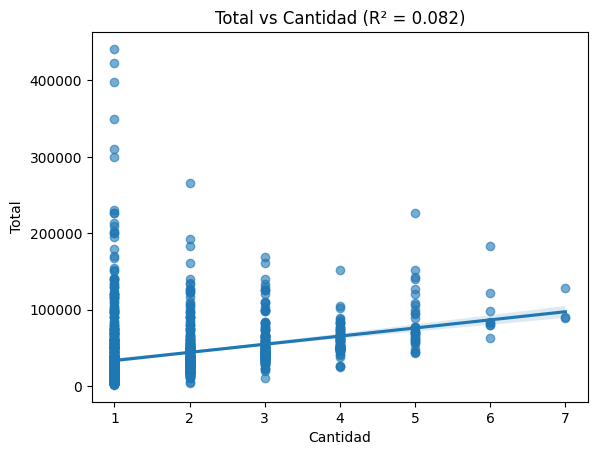

In [181]:
# Regresión simple: Total ~ Neto
df_reg = df.dropna(subset=["Total", "Cantidad"]).copy()
X = sm.add_constant(df_reg[["Cantidad"]])
y = df_reg["Total"]

modelo = sm.OLS(y, X).fit()
print("Regresión lineal: Total ~ Cantidad")
print(modelo.summary())

# Visualización
sns.regplot(data=df_reg, x="Cantidad", y="Total", scatter_kws={"alpha": 0.6})
plt.title(f"Total vs Cantidad (R² = {modelo.rsquared:.3f})")
plt.show()

Regresión lineal: Total ~ Costo venta
                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 8.962e+04
Date:                Thu, 19 Feb 2026   Prob (F-statistic):               0.00
Time:                        00:33:13   Log-Likelihood:                -13881.
No. Observations:                1395   AIC:                         2.777e+04
Df Residuals:                    1393   BIC:                         2.778e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       

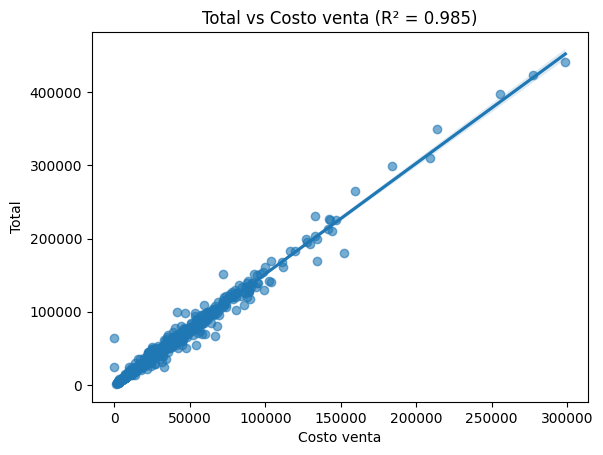

In [182]:
# Regresión simple: Total ~ Neto
df_reg = df.dropna(subset=["Total", "Costo venta"]).copy()
X = sm.add_constant(df_reg[["Costo venta"]])
y = df_reg["Total"]

modelo = sm.OLS(y, X).fit()
print("Regresión lineal: Total ~ Costo venta")
print(modelo.summary())

# Visualización
sns.regplot(data=df_reg, x="Costo venta", y="Total", scatter_kws={"alpha": 0.6})
plt.title(f"Total vs Costo venta (R² = {modelo.rsquared:.3f})")
plt.show()

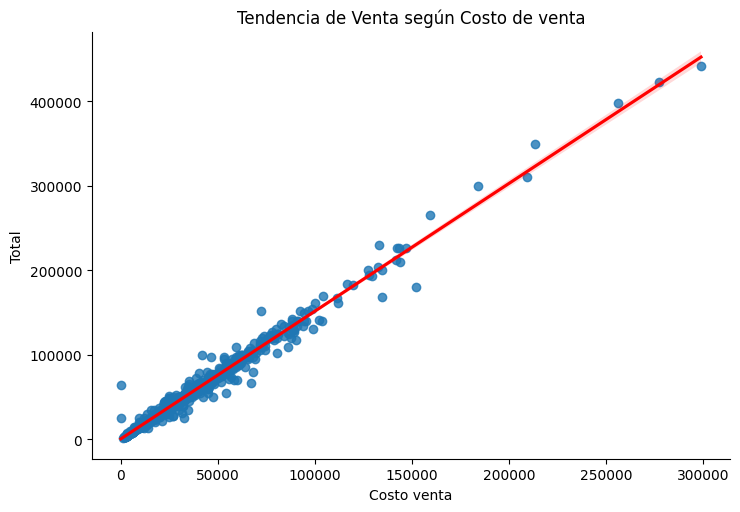

In [184]:
sns.lmplot(data=df, x='Costo venta', y='Total', aspect=1.5, line_kws={'color': 'red'})
plt.title('Tendencia de Venta según Costo de venta')
plt.show()

In [186]:
# 1. Definimos las variables X (lo que explica) y Y (lo que queremos predecir)
X = df['Cantidad']
y_true = df['Total']

# 2. Creamos y ajustamos el modelo (usando statsmodels como preguntaste antes)
X = sm.add_constant(X) # Añadimos la constante para el intercepto
modelo = sm.OLS(y_true, X).fit()

# 3. Generamos las predicciones
y_pred = modelo.predict(X)

# 4. Ahora ya puedes calcular las métricas
print(f"MAE: {mean_absolute_error(y_true, y_pred):,.0f}")
print(f"R2: {r2_score(y_true, y_pred):.4f}")

MAE: 23,231
R2: 0.0823


In [187]:
# Supongamos que:
# y_true son los valores reales de tu columna 'Total'
# y_pred son los valores que tu modelo predijo

r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f"R² (Coeficiente de Determinación): {r2:.4f}")
print(f"MSE (Error Cuadrático Medio): {mse:.2f}")
print(f"MAE (Error Absoluto Medio): {mae:.2f}")

R² (Coeficiente de Determinación): 0.0823
MSE (Error Cuadrático Medio): 1543862626.92
MAE (Error Absoluto Medio): 23230.76


In [191]:
# En este caso usaremos los datos sin los valores atípicos
# Para diferenciar entre atípicos y normales
# Normal: Mantención
# Atípicos: Reparación Mayor
# 1. Filtramos los datos para quedarnos solo con "Mantención" (Ventas <= 97.500)
df_mantencion = df[df['Total'] <= 97500].copy()

# 2. Definimos y_true y X
y_true = df_mantencion['Total']
X = df_mantencion['Cantidad']
X = sm.add_constant(X) # Necesario para que el modelo tenga intercepto

# 3. Ajustamos el modelo y generamos y_pred
modelo_m = sm.OLS(y_true, X).fit()
y_pred = modelo_m.predict(X)

# 4. Calculamos el R2
r2_mantencion = r2_score(y_true, y_pred)

print(f"Resultados para el segmento de Mantención:")
print(f"R-cuadrado: {r2_mantencion:.4f}")
print(f"Ticket promedio base (Intercepto): ${modelo_m.params[0]:,.0f}")
print(f"Aumento por cada producto extra: ${modelo_m.params[1]:,.0f}")

Resultados para el segmento de Mantención:
R-cuadrado: 0.3148
Ticket promedio base (Intercepto): $13,341
Aumento por cada producto extra: $11,237


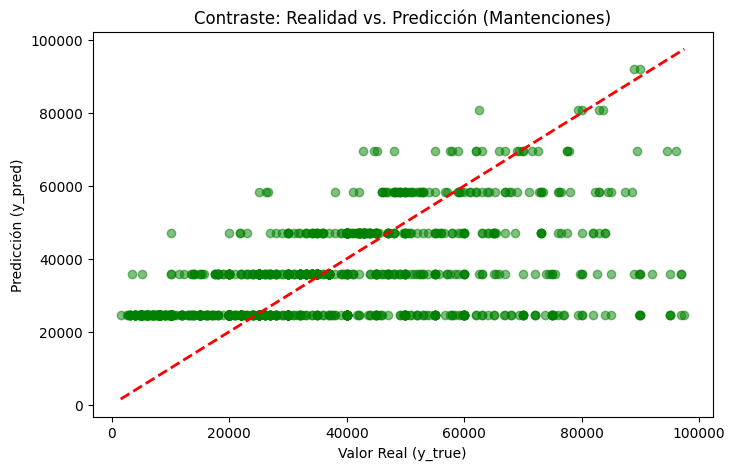

In [189]:
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.5, color='green')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Valor Real (y_true)')
plt.ylabel('Predicción (y_pred)')
plt.title('Contraste: Realidad vs. Predicción (Mantenciones)')
plt.show()

##Lección 5:ANÁLISIS VISUAL DE DATOS

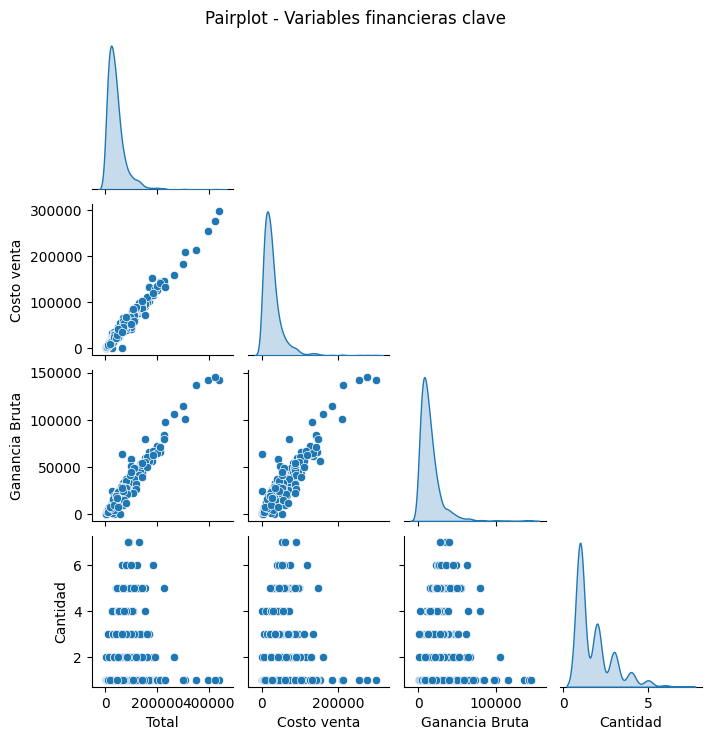

In [190]:
# 1. PAIRPLOT - Relaciones multivariables
sns.pairplot(
    df[["Total", "Costo venta", "Ganancia Bruta", "Cantidad"]].dropna(),
    diag_kind="kde",
    corner=True,
    height=1.8
)
plt.suptitle("Pairplot - Variables financieras clave", y=1.02)
plt.show()


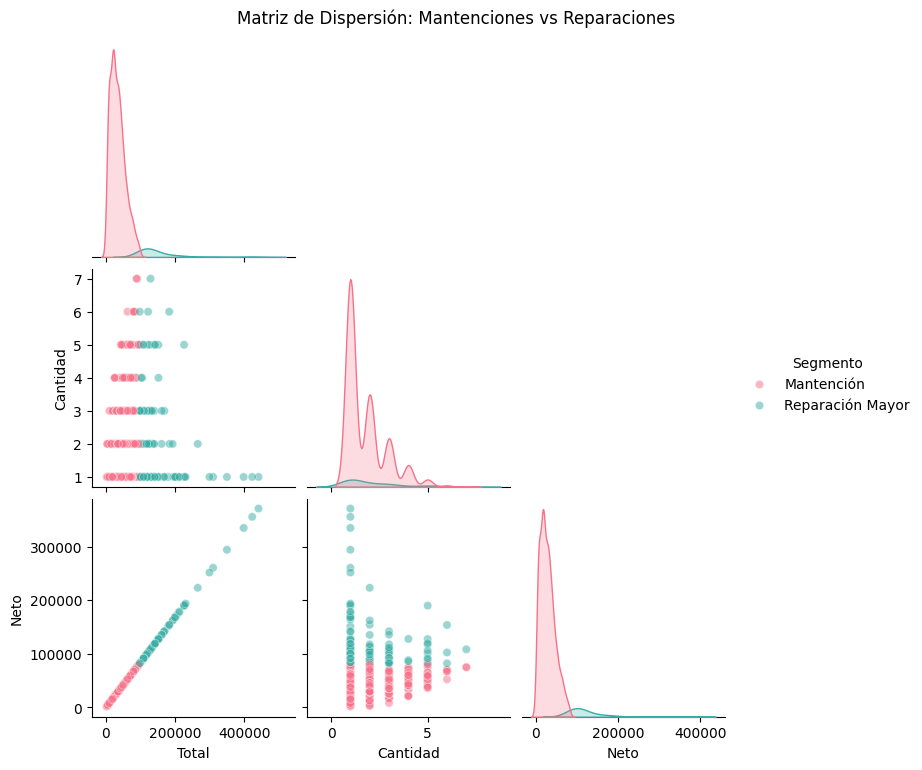

In [192]:
#En esta representación gráfica se consideran valores normales y atípicos por separado

# 1. Creamos la etiqueta de segmento para que el gráfico sea más informativo
df['Segmento'] = df['Total'].apply(lambda x: 'Reparación Mayor' if x > 97500 else 'Mantención')

# 2. Seleccionamos las columnas que queremos comparar
# Es mejor no meter todas para que el gráfico no sea gigante y lento
cols_interes = ['Total', 'Cantidad', 'Neto', 'Segmento']

# 3. Generamos el Pairplot
sns.pairplot(
    df[cols_interes],
    hue='Segmento',           # Color según el tipo de venta
    palette='husl',           # Paleta de colores vibrantes
    corner=True,              # Evita mostrar la mitad repetida de la matriz
    diag_kind='kde',          # Muestra curvas de densidad en la diagonal
    plot_kws={'alpha': 0.5}   # Transparencia para ver puntos encimados
)

plt.suptitle('Matriz de Dispersión: Mantenciones vs Reparaciones', y=1.02)
plt.show()

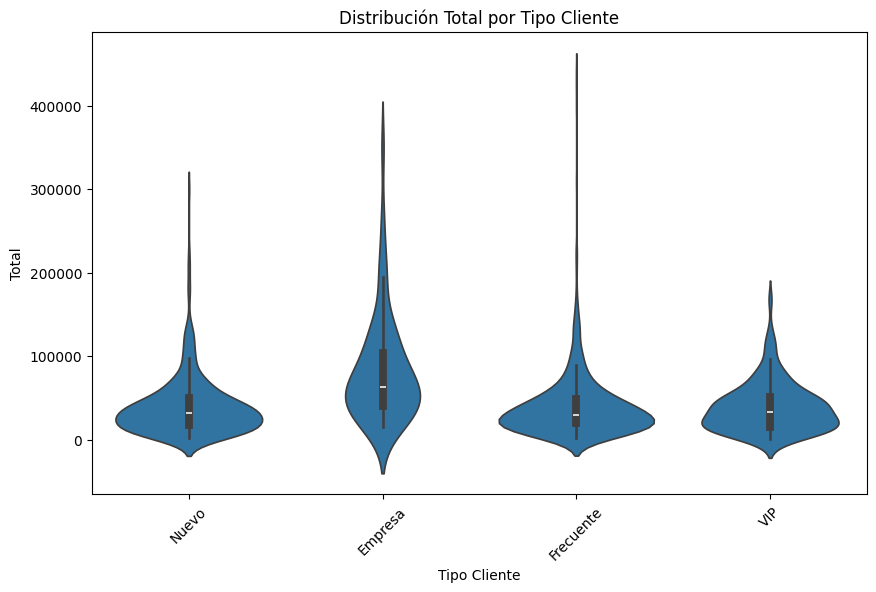

In [193]:
# 2. VIOLINPLOT - Distribución por Tipo Cliente
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="Tipo Cliente", y="Total")
plt.title("Distribución Total por Tipo Cliente")
plt.xticks(rotation=45)
plt.show()


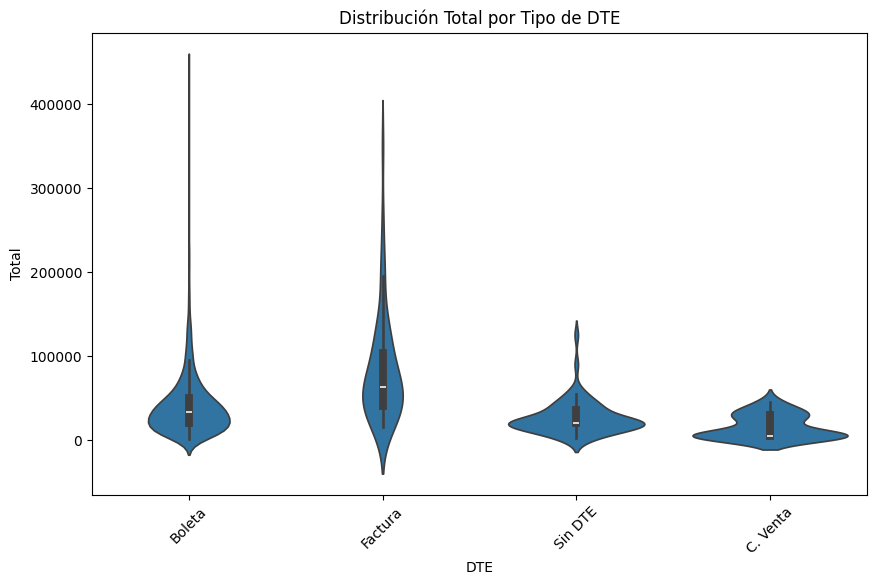

In [194]:
# 2. VIOLINPLOT - Distribución por Tipo DTE
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="DTE", y="Total")
plt.title("Distribución Total por Tipo de DTE")
plt.xticks(rotation=45)
plt.show()

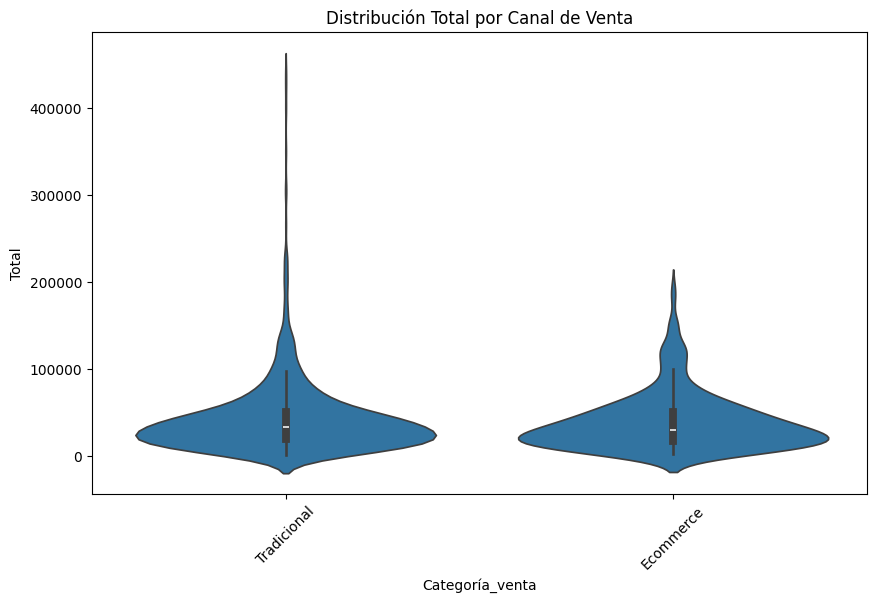

In [195]:
# 2. VIOLINPLOT - Distribución por Canal de venta
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="Categoría_venta", y="Total")
plt.title("Distribución Total por Canal de Venta")
plt.xticks(rotation=45)
plt.show()

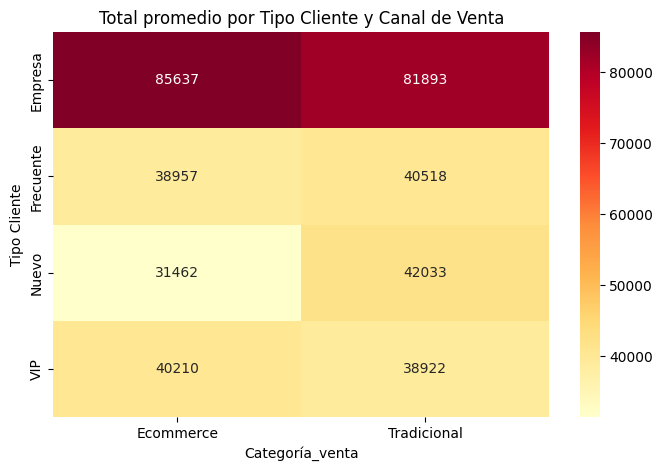

In [196]:
# 3. HEATMAP - Correlación por Categoría Venta
pivot_corr = df.pivot_table(
    values="Total",
    index="Tipo Cliente",
    columns="Categoría_venta",
    aggfunc="mean"
)
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_corr, annot=True, cmap="YlOrRd", fmt=".0f")
plt.title("Total promedio por Tipo Cliente y Canal de Venta")
plt.show()


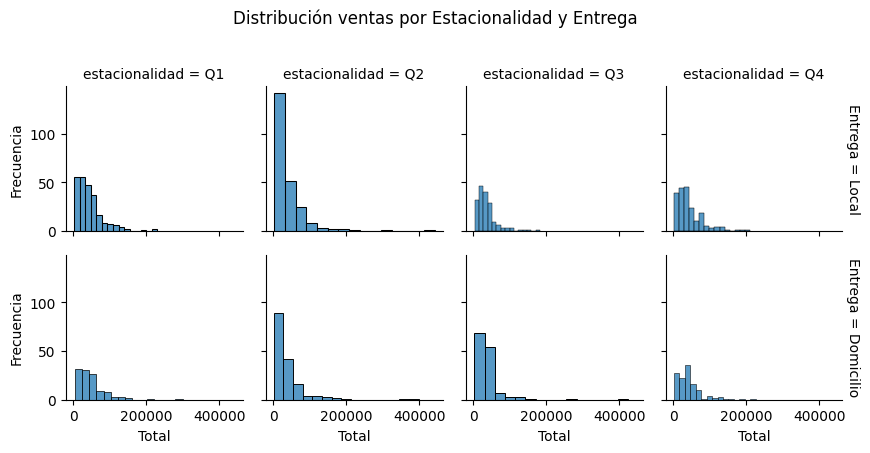

In [197]:
# 4. FACETGRID - Total por Estacionalidad y Entrega
g = sns.FacetGrid(
    df,
    col="estacionalidad",
    row="Entrega",
    margin_titles=True,
    height=2.2
)
g.map_dataframe(sns.histplot, x="Total", bins=15, kde=False)
g.set_axis_labels("Total", "Frecuencia")
plt.suptitle("Distribución ventas por Estacionalidad y Entrega", y=1.02)
plt.tight_layout()
plt.show()


##Lección 6: LIBRERÍA MATPLOTLIB

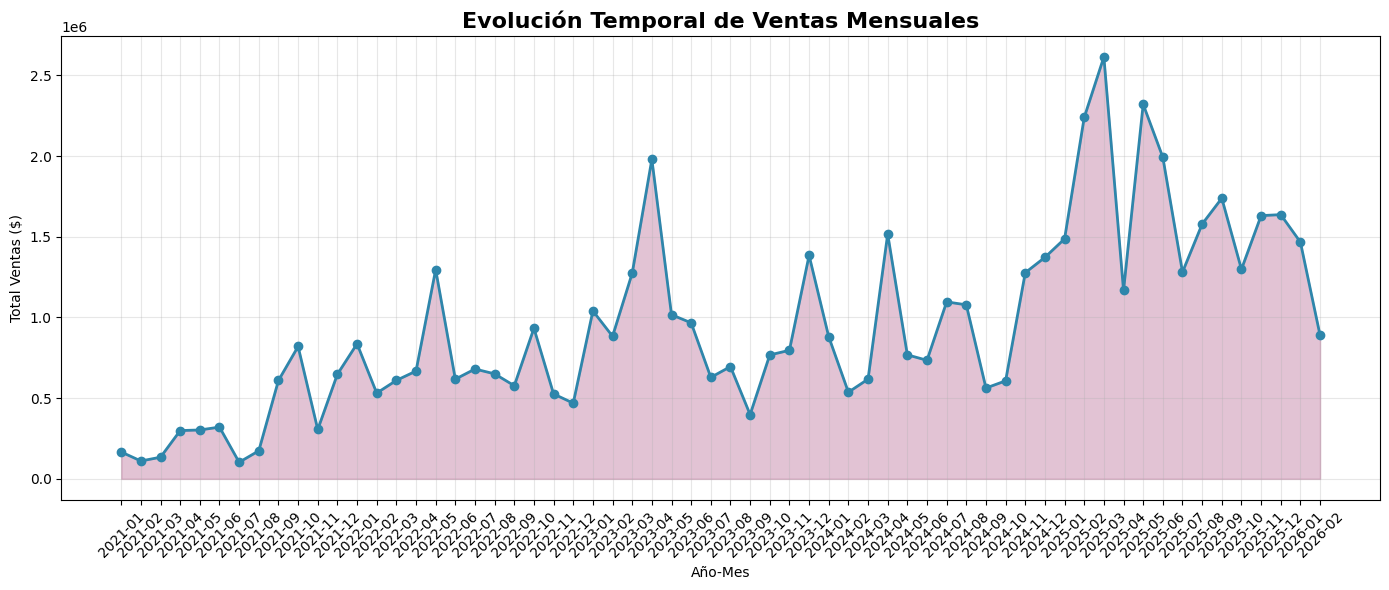

In [198]:
# 1. Evolución temporal (Ventas mensuales)
df["anio_mes"] = df["Fecha"].dt.to_period("M")
ventas_mensuales = df.groupby("anio_mes")["Total"].sum().reset_index()
ventas_mensuales["anio_mes"] = ventas_mensuales["anio_mes"].astype(str)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(ventas_mensuales["anio_mes"], ventas_mensuales["Total"],
        marker="o", linewidth=2, markersize=6, color="#2E86AB")
ax.fill_between(ventas_mensuales["anio_mes"], ventas_mensuales["Total"],
                alpha=0.3, color="#A23B72")
ax.set_title("Evolución Temporal de Ventas Mensuales", fontsize=16, fontweight="bold")
ax.set_xlabel("Año-Mes")
ax.set_ylabel("Total Ventas ($)")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


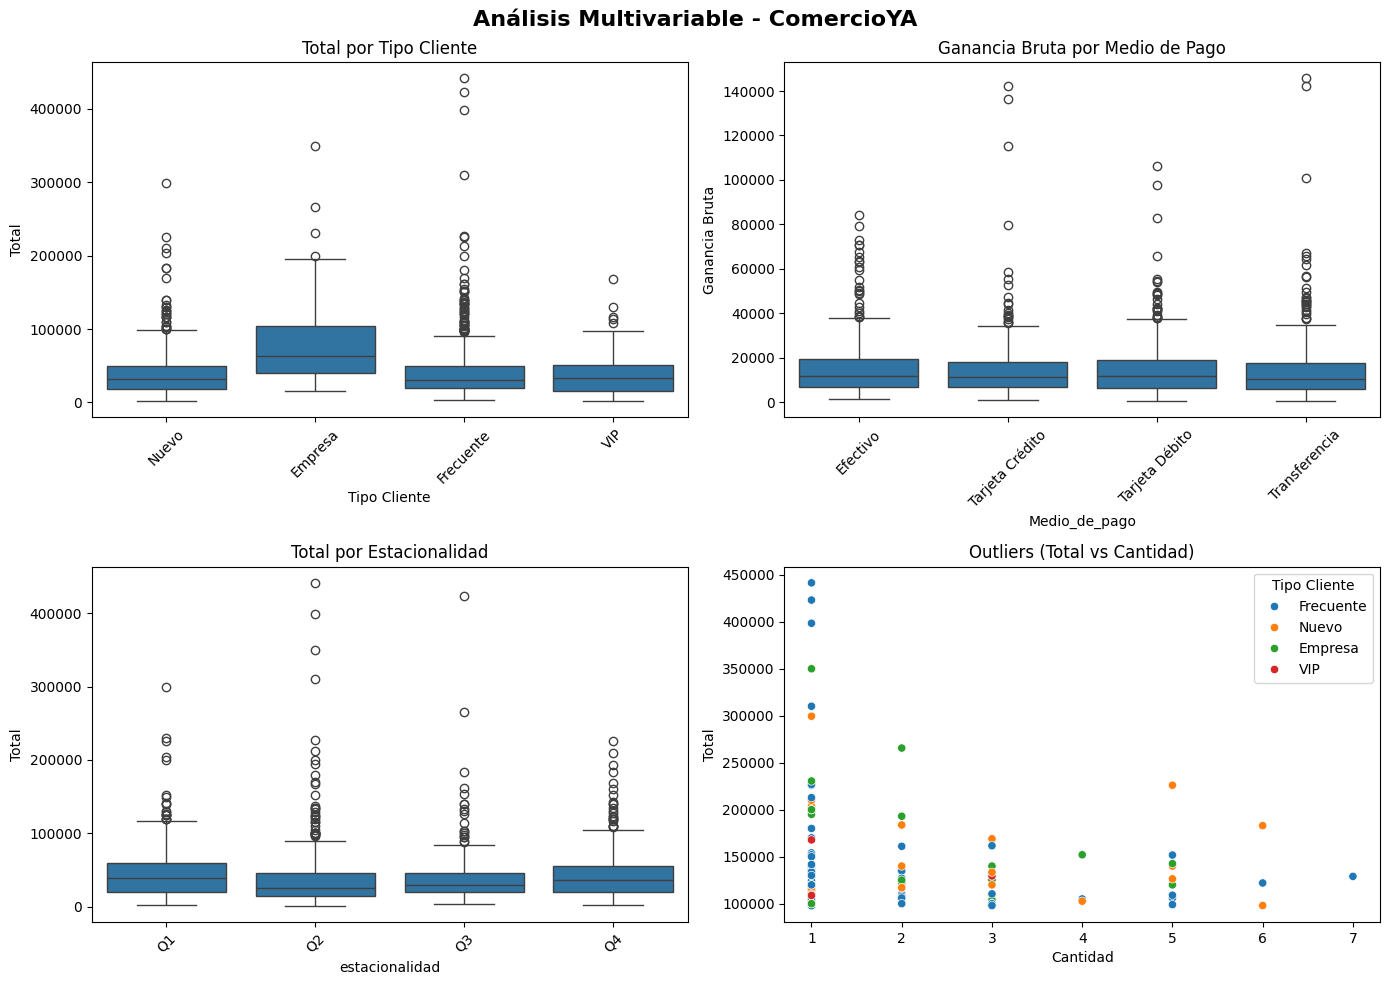

In [201]:
# 2. Subplots comparativos (por canal de venta)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total por Tipo Cliente
sns.boxplot(data=df, x="Tipo Cliente", y="Total", ax=axes[0,0])
axes[0,0].set_title("Total por Tipo Cliente")
axes[0,0].tick_params(axis='x', rotation=45)

# Ganancia Bruta por Medio de Pago
sns.boxplot(data=df, x="Medio_de_pago", y="Ganancia Bruta", ax=axes[0,1])
axes[0,1].set_title("Ganancia Bruta por Medio de Pago")
axes[0,1].tick_params(axis='x', rotation=45)

# Total por Estacionalidad
sns.boxplot(data=df, x="estacionalidad", y="Total", ax=axes[1,0])
axes[1,0].set_title("Total por Estacionalidad")
axes[1,0].tick_params(axis='x', rotation=45)

# Outliers destacados
outliers = df[df["es_atipico"] == True]
sns.scatterplot(data=outliers, x="Cantidad", y="Total", hue="Tipo Cliente", ax=axes[1,1])
axes[1,1].set_title("Outliers (Total vs Cantidad)")

plt.suptitle("Análisis Multivariable - ComercioYA", fontsize=16, fontweight="bold", y=0.98)
plt.tight_layout()
plt.show()


✅ 1. Dataset final: ComercioYA_ventas_completo.csv


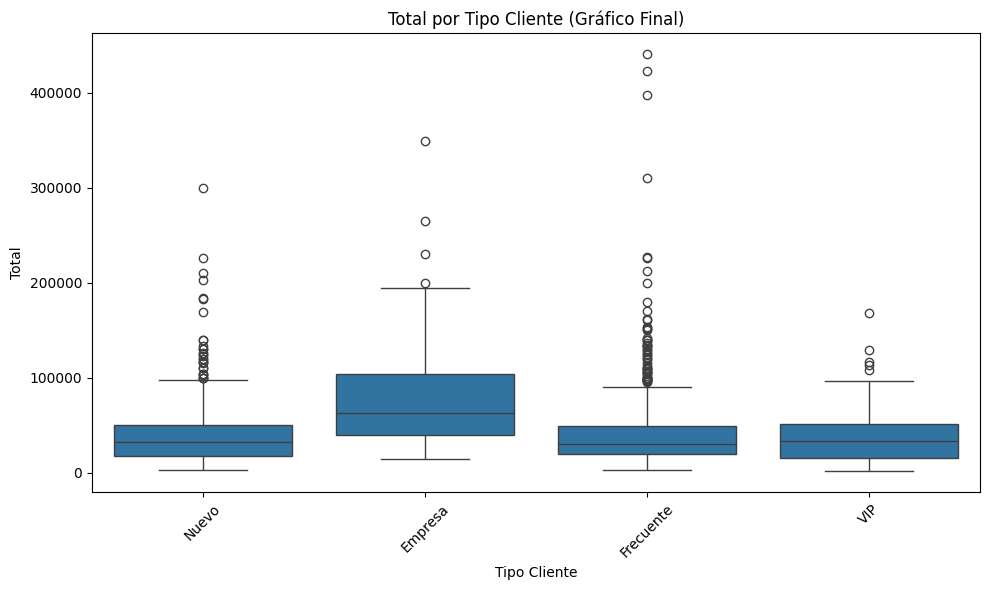

✅ 2. Gráfico final: grafico_final_tipo_cliente.png
✅ 3. Resumen ejecutivo:
   Total_registros: 1395
   Total_ventas: $58,628,438
   Promedio_ticket: $42028
   Distribucion_clientes: {np.str_('Frecuente'): 802, np.str_('Nuevo'): 414, np.str_('VIP'): 114, 'Empresa': 65}
   Top_categoria: Frecuente
   Rango_fechas: Jan 2021 - Feb 2026


In [202]:
# =====================================================================
# EXPORTACIÓN DE RESULTADOS (Entregables del proyecto)
# =====================================================================

# 1. Dataset final
df.to_csv("ComercioYA_ventas_completo.csv", index=False)
print("✅ 1. Dataset final: ComercioYA_ventas_completo.csv")

# 2. Gráficos clave
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x="Tipo Cliente", y="Total", ax=ax)
ax.set_title("Total por Tipo Cliente (Gráfico Final)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("grafico_final_tipo_cliente.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ 2. Gráfico final: grafico_final_tipo_cliente.png")

# 3. Resumen ejecutivo para informe
resumen_ejecutivo = {
    "Total_registros": len(df),
    "Total_ventas": f"${df['Total'].sum():,.0f}",
    "Promedio_ticket": f"${df['Total'].mean():.0f}",
    #"Outliers": df["es_outlier"].sum(),
    "Distribucion_clientes": df["Tipo Cliente"].value_counts().to_dict(),
    "Top_categoria": df["Tipo Cliente"].value_counts().index[0],
    "Rango_fechas": f"{df['Fecha'].min().strftime('%b %Y')} - {df['Fecha'].max().strftime('%b %Y')}"
}
print("✅ 3. Resumen ejecutivo:")
for k, v in resumen_ejecutivo.items():
    print(f"   {k}: {v}")

